# High Value Customer Identification

## Solution Planning - IOT

### Inputs

1. Business problem
    - Select the most valuable clients to integrate with a loyalty program.

2. Data set
    - Sales of an online e-commerce during the period of a year.

### Output

1. The indication of people who will be part of the insiders program.
    - List: client_id | is_insider |

    Example:
        10451 | yes
        10452 | no

2. Report with Business Questions
    - Who are the eligible people to join the Insiders program?
    - How many clients will be part of the group?
    - What are the main characteristics of these clients?
    - What is the revenue contribution percentage coming from Insiders?
    - What is the revenue forecast for this group in the upcoming months?
    - What are the conditions for someone to be eligible for the Insiders program?
    - What are the conditions for someone to be removed from the Insiders program?
    - What guarantees that the Insiders program performs better than the rest of the client base?
    - What actions can the marketing team take to increase revenue?m

### Tasks

#### 1. Who are the eligible people to join the Insiders program?

* **What defines an eligible customer? Who are the clients with the highest value?**

    * **Financial Metrics (Invoicing):**
        * High Average Ticket (e.g., 1, 10, 50, 34 - *These seem to be placeholder values or examples, actual thresholds to be determined*)
        * High Lifetime Value (LTV)
        * Low Recency (i.e., purchased recently)
        * High Basket Size (number of items per purchase)
        * Low Churn Probability
        * High Purchase Propensity (likelihood to buy)

    * **Cost Metrics:**
        * Low Return Rate

    * **Shopping Experience:**
        * High Average Ratings/Reviews

---

#### 2. How many clients will be part of the group?

* Determine the percentage of the total client base that will be included in the Insiders group.

---

#### 3. What are the main characteristics of these clients?

* **Customer Demographics/Attributes:**
    * Location
    * Age (if available)

* **Consumption Characteristics:**
    * Attributes derived from Clustering (e.g., product categories purchased, frequency patterns, preferred channels)

---

#### 4. What is the revenue contribution percentage coming from Insiders?

* Calculate the total annual revenue.
* Calculate the revenue generated specifically by the Insiders group.
* Determine the percentage contribution of the Insiders group to the total revenue.

---

#### 5. What is the revenue forecast for this group in the upcoming months?

* Calculate the LTV of the Insiders group.
* Perform Cohort Analysis to understand revenue trends and predict future performance.

---

#### 6. What are the conditions for someone to be eligible for the Insiders program?

* **Periodicity:** Define the review frequency (e.g., every 1 month, every 3 months) for eligibility.
* **Eligibility Criteria:** A person needs to be similar to or closely resemble an existing member of the Insiders group based on defined attributes.

---

#### 7. What are the conditions for someone to be removed from the Insiders program?

* **Periodicity:** Define the review frequency (e.g., every 1 month, every 3 months) for removal.
* **Removal Criteria:** A person needs to become dissimilar to or not resemble an existing member of the Insiders group based on defined attributes.

---

#### 8. What guarantees that the Insiders program performs better than the rest of the client base?

* **A/B Testing:** Design and execute A/B tests comparing the Insiders group's performance against a control group.
* **Hypothesis Testing:** Formulate and test statistical hypotheses to validate the program's effectiveness.
* **Bayesian A/B Testing:** Utilize Bayesian methods for more robust A/B test analysis.

---

#### 9. What actions can the marketing team take to increase revenue?

* **Discounts:** Offer exclusive discounts to Insiders.
* **Purchase Preference:** Provide early access or priority for new products/sales.
* **Shipping Benefits:** Offer free or expedited shipping.

### Benchmark de Soluções

Define MVP and other possible solutions

### RFM Model: Customer Segmentation



        

# Imports

In [43]:
import sys
from pathlib import Path

# Get the current notebook's directory (using the current working directory)
NOTEBOOK_DIR = Path.cwd()

# Navigate up to the project root (assumes notebook is in ./notebooks)
ROOT_DIR = NOTEBOOK_DIR.parent

# Path to the 'src' directory
SRC_DIR = ROOT_DIR / "src"

# Add 'src' to Python path so we can import modules like 'data.load_data'
sys.path.append(str(SRC_DIR))


In [131]:
import numpy                 as np
import pandas                as pd
%matplotlib inline
import matplotlib.pyplot     as plt
import seaborn               as sns
import umap.umap_            as umap
import sklearn.preprocessing as pp
import warnings
import re

from data.load_data             import load_ecommerce_data
from features.transform_columns import to_snake_case_columns
from sklearn.cluster            import KMeans
from yellowbrick.cluster        import KElbowVisualizer, SilhouetteVisualizer
from sklearn.metrics            import silhouette_score
from plotly                     import express as px
from ydata_profiling            import ProfileReport 
from sklearn.decomposition      import PCA
from sklearn.manifold           import TSNE
from sklearn.ensemble           import RandomForestRegressor


warnings.filterwarnings('ignore')


# Load Dataset

In [45]:
# Load data
df_raw = load_ecommerce_data("../data/raw/Ecommerce.csv")

df_raw.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,29-Nov-16,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,29-Nov-16,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,29-Nov-16,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,29-Nov-16,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,29-Nov-16,3.39,17850.0,United Kingdom


# <font color='blue'> 📊  1.0 Data Description

## <span style="color:blue">1.1</span> Rename Columns

In [46]:
df1 = df_raw.copy()

In [47]:
df1 = to_snake_case_columns(df1)
df1.head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,29-Nov-16,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,29-Nov-16,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,29-Nov-16,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,29-Nov-16,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,29-Nov-16,3.39,17850.0,United Kingdom


## <span style="color:blue">1.2</span> Data Dimensions

In [48]:
print(f'Number of rows: {df1.shape[0]}')
print(f'Number of columns: {df1.shape[1]}')

Number of rows: 541909
Number of columns: 8


## <span style="color:blue">1.3</span> Data Types

In [49]:
df1.dtypes

invoice_no       object
stock_code       object
description      object
quantity          int64
invoice_date     object
unit_price      float64
customer_id     float64
country          object
dtype: object

## <span style="color:blue">1.4</span> Check NA

In [50]:
df1.isna().sum()

invoice_no           0
stock_code           0
description       1454
quantity             0
invoice_date         0
unit_price           0
customer_id     135080
country              0
dtype: int64

## <span style="color:blue">1.5</span> Replace NA

In [51]:
# Get NA records
df_missing = df1.loc[df1['customer_id'].isna(), :]
# Det not NA records
df_not_missing  = df1.loc[~df1['customer_id'].isna(), :]

In [52]:
# create auxiliary dataframe with missing customer_id
df_backup = pd.DataFrame(df_missing['invoice_no'].drop_duplicates())
df_backup['customer_id'] = np.arange(19000, 19000 + len(df_backup), 1)

# merge auxiliary dataframe with df_missing
df_missing.drop(columns=['customer_id'], inplace=True)
df_missing = df_missing.merge(df_backup, on='invoice_no', how='left')

# concatenate df_not_missing and df_missing
df1 = pd.concat([df_not_missing, df_missing], axis=0)

df1.head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,29-Nov-16,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,29-Nov-16,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,29-Nov-16,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,29-Nov-16,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,29-Nov-16,3.39,17850.0,United Kingdom


In [53]:
df1.isna().sum()

invoice_no         0
stock_code         0
description     1454
quantity           0
invoice_date       0
unit_price         0
customer_id        0
country            0
dtype: int64

## <span style="color:blue">1.6</span> Change dtype

In [54]:
# invoice_date
df1['invoice_date'] = pd.to_datetime(df1['invoice_date'], format='%d-%b-%y')

# customer id
df1['customer_id'] = df1['customer_id'].astype(int)

df1.head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2016-11-29,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2016-11-29,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2016-11-29,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2016-11-29,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2016-11-29,3.39,17850,United Kingdom


In [55]:
df1.dtypes

invoice_no              object
stock_code              object
description             object
quantity                 int64
invoice_date    datetime64[ns]
unit_price             float64
customer_id              int64
country                 object
dtype: object

## <span style="color:blue">1.7</span> Descriptive Statistics

In [56]:
num_attributes = df1.select_dtypes(include=['int64', 'float64'])
cat_attributes = df1.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])

### <span style="color:blue">1.7.1</span> Numerical Attributes

In [57]:
# Calculate all desired statistics at once (central and dispersion)
stats = pd.DataFrame({
    'mean': num_attributes.mean(),
    'median': num_attributes.median(),
    'std': num_attributes.std(),
    'min': num_attributes.min(),
    'max': num_attributes.max(),
    'range': num_attributes.max() - num_attributes.min(),
    'skew': num_attributes.skew(),
    'kurtosis': num_attributes.kurtosis()
})

# Display the statistics
print("Numerical Attributes Statistics:")
stats

Numerical Attributes Statistics:


,mean,median,std,min,max,range,skew,kurtosis
quantity,9.552250,3.00,218.081158,-80995.00,80995.0,161990.00,-0.264076,119769.160031
unit_price,4.611114,2.08,96.759853,-11062.06,38970.0,50032.06,186.506972,59005.719097
customer_id,16688.840453,16249.00,2911.411352,12346.00,22709.0,10363.00,0.487449,-0.804287


#### <span style="color:blue">1.7.1</span> Numerical Attributes - Investigating

1. Negative Quantity may be devolution

2. Null unit price (may be a promotion)

### <span style="color:blue">1.7.2</span> Categorical Attributes

In [58]:
cat_attributes.head()

,invoice_no,stock_code,description,country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,United Kingdom
1,536365,71053,WHITE METAL LANTERN,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,United Kingdom


#### Invoice No

In [59]:
unique_invoices_with_letters = (~pd.Series(df1['invoice_no'].unique()).str.isnumeric()).sum()

# Display the count
print(f"Number of unique invoice_no containing letters: {unique_invoices_with_letters}")

Number of unique invoice_no containing letters: 3839


In [60]:
df_letter_invoices = df1.loc[df1['invoice_no'].apply(lambda x: bool(re.search(r'[a-zA-Z]', x))), :]
df_letter_invoices.head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
141,C536379,D,Discount,-1,2016-11-29,27.50,14527,United Kingdom
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2016-11-29,4.65,15311,United Kingdom
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2016-11-29,1.65,17548,United Kingdom
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2016-11-29,0.29,17548,United Kingdom
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2016-11-29,0.29,17548,United Kingdom


In [61]:
print('Total number of invoices: {}'.format(len(df_letter_invoices)))
print('Total number of negative invoices: {}'.format(len(df_letter_invoices[df_letter_invoices['quantity'] < 0])))

Total number of invoices: 9291
Total number of negative invoices: 9288


#### Stock Code

In [62]:
unique_stock_codes_with_letters = (~pd.Series(df1['stock_code'].unique()).str.isnumeric()).sum()
print(f"Number of unique stock_code containing letters: {unique_stock_codes_with_letters}")

# Display unique stock codes that contain only letters
print("\nUnique stock codes that contain only letters:")
print(df1.loc[df1['stock_code'].apply(lambda x: bool(re.search(r'^[a-zA-Z]+$', x))),'stock_code'].unique())

# Action:
## 1. Remove stock_code in ['POST' 'D' 'M' 'PADS' 'DOT' 'CRUK']

Number of unique stock_code containing letters: 1124

Unique stock codes that contain only letters:
['POST' 'D' 'M' 'PADS' 'DOT' 'CRUK' 'S' 'AMAZONFEE' 'm' 'DCGSSBOY'
 'DCGSSGIRL' 'B']


#### Description

In [63]:
# Action:
## 1. Delete description columns. At first moment no other column can be created from it.

#### Country

In [64]:
print('Total number of different countries: {}'.format(df1['country'].nunique()))

Total number of different countries: 38


In [65]:
df1['country'].value_counts(normalize=True).head()

country
United Kingdom    0.914320
Germany           0.017521
France            0.015790
EIRE              0.015124
Spain             0.004674
Name: proportion, dtype: float64

In [66]:
# Get number of unique customers by country
unique_customers_by_country = df1.groupby('country')['customer_id'].nunique().reset_index()
unique_customers_by_country.columns = ['country', 'unique_customers']

# Sort by number of unique customers
unique_customers_by_country = unique_customers_by_country.sort_values(by='unique_customers', ascending=False)

# Display the top 5 result
unique_customers_by_country.head()


,country,unique_customers
36,United Kingdom,7587
14,Germany,95
13,France,90
10,EIRE,44
31,Spain,31


# <font color='blue'> 🧹2.0 Data Filtering

In [67]:
df2 = df1.copy()

In [68]:
df2.dtypes

invoice_no              object
stock_code              object
description             object
quantity                 int64
invoice_date    datetime64[ns]
unit_price             float64
customer_id              int64
country                 object
dtype: object

In [69]:

# === Numerical attributes ===
df2 = df2.loc[df2['unit_price'] >= 0.04, :]

# === Categorical attributes ====
df2 = df2[~df2['stock_code'].isin( ['POST', 'D', 'DOT', 'M', 'S', 'AMAZONFEE', 'm', 'DCGSSBOY', 'DCGSSGIRL', 'PADS', 'B', 'CRUK'] ) ]

# Remove column description
df2.drop(columns=['description'], inplace=True)

# country
df2 = df2[~df2['country'].isin(['European Community', 'Unspecified'])]

# quantity
df2_returns = df2.loc[df2['quantity'] < 0, :]
df2_purchases = df2.loc[df2['quantity'] > 0, :]


# <font color='blue'> ⚙️ 3.0 Feature Engineering

#### Feature Ideas:
 - Moving Average - 7d, 14d, 30d
 - Quantity of purchases before 15th day and after 15th day of the month

In [70]:
df3= df2.copy()

In [71]:
df3.shape

(536143, 7)

## <span style="color:blue">3.1</span> Feature Creation

In [72]:
# data reference
df_ref = (
    df3.drop( ['invoice_no', 'stock_code', 'quantity', 'invoice_date', 'unit_price', 'country'], axis=1 )
    .drop_duplicates( ignore_index=True )
)

### <span style="color:blue">3.1.1 </span> Gross Revenue



In [73]:
# Gross Revenue - Quantity * Unit Price
df2_purchases.loc[:, 'gross_revenue'] = df2_purchases.loc[:, 'quantity'] * df2_purchases.loc[:, 'unit_price']

# Monetary
df_monetary = df2_purchases.loc[:, ['customer_id', 'gross_revenue']].groupby( 'customer_id' ).sum().reset_index()
df_ref = pd.merge( df_ref, df_monetary, on='customer_id', how='left' )
df_ref.isna().sum()

customer_id       0
gross_revenue    91
dtype: int64

### <span style="color:blue">3.1.2</span> Recency - Day from Last Purchase

In [74]:
# Recency - Last Day Purchase
df_recency = (
    df2_purchases[['customer_id', 'invoice_date']]
    .groupby('customer_id').max().reset_index()
    .rename(columns={'invoice_date': 'last_day_purchase'})
)

df_recency['recency_days'] = (df2_purchases['invoice_date'].max() - df_recency['last_day_purchase']).dt.days
df_ref = pd.merge(df_ref, df_recency[['customer_id', 'recency_days']], on='customer_id', how='left')
df_ref.isna().sum()

customer_id       0
gross_revenue    91
recency_days     91
dtype: int64

### <span style="color:blue">3.1.3</span> Quantity of Purchases

In [75]:
# Frequency - Number of Purchases
df_frequency = df2_purchases[['customer_id', 'invoice_no']]. \
                  drop_duplicates().groupby('customer_id').\
                  count().reset_index().rename(columns={'invoice_no': 'qtde_invoices'})

df_ref = pd.merge(df_ref, df_frequency, on='customer_id', how='left')
df_ref.isna().sum()

customer_id       0
gross_revenue    91
recency_days     91
qtde_invoices    91
dtype: int64

### <span style="color:blue">3.1.4</span> Quantity Total of Items Purchased

In [76]:
# Number of Products Purchased
df_frequency = df2_purchases[['customer_id', 'quantity']].\
                    groupby('customer_id').sum().\
                    reset_index().rename(columns={'quantity': 'qtde_items'})

df_ref = pd.merge(df_ref, df_frequency, on='customer_id', how='left')
df_ref.isna().sum()

customer_id       0
gross_revenue    91
recency_days     91
qtde_invoices    91
qtde_items       91
dtype: int64

### <span style="color:blue">3.1.5</span> Quantity of products purchased 

In [77]:
# Numero de produtos
df_freq = df2_purchases[['customer_id', 'stock_code']].\
            groupby( 'customer_id' ).count().\
            reset_index().\
            rename( columns={'stock_code': 'qtde_products'} )

df_ref = pd.merge( df_ref, df_freq, on='customer_id', how='left' )
df_ref.isna().sum()

customer_id       0
gross_revenue    91
recency_days     91
qtde_invoices    91
qtde_items       91
qtde_products    91
dtype: int64

### <span style="color:blue">3.1.6</span> Avg Ticket

In [78]:
# Avg Ticket -  Gross Revenue / Frequency
df_avg_ticket = (
    df2_purchases[['customer_id', 'gross_revenue']]
    .groupby('customer_id').mean().reset_index().rename(columns={'gross_revenue': 'avg_ticket'})
)
df_ref = pd.merge(df_ref, df_avg_ticket, on='customer_id', how='left')
df_ref.isna().sum()

customer_id       0
gross_revenue    91
recency_days     91
qtde_invoices    91
qtde_items       91
qtde_products    91
avg_ticket       91
dtype: int64

### <span style="color:blue">3.1.7</span> Average Recency Days

In [79]:
# Select customer ID and invoice date, drop duplicates
df_aux = df2[['customer_id', 'invoice_date']].drop_duplicates()

# Sort by customer and invoice date (most recent first)
df_aux = df_aux.sort_values(['customer_id', 'invoice_date'], ascending=[False, False])

# Compute recency using groupby and diff
df_aux['recency'] = df_aux.groupby('customer_id')['invoice_date'].diff(-1).dt.days

# Group by customer and compute average recency
df_avg_recency = (
    df_aux[['customer_id', 'recency']]
    .groupby('customer_id')
    .mean()
    .reset_index()
    .rename(columns={'recency': 'avg_recency_days'})
)

# Merge with reference DataFrame
df_ref = pd.merge(df_ref, df_avg_recency, on='customer_id', how='left')

df_ref.isna().sum()

customer_id            0
gross_revenue         91
recency_days          91
qtde_invoices         91
qtde_items            91
qtde_products         91
avg_ticket            91
avg_recency_days    2816
dtype: int64

### <span style="color:blue">3.1.8</span> Purchase Frequency

In [80]:
# Step 1: Create an auxiliary DataFrame with purchase activity summary for each customer
df_aux = (
    df2_purchases[['customer_id', 'invoice_no', 'invoice_date']]  # Select relevant columns
    .drop_duplicates()  # Remove duplicate purchase records
    .groupby('customer_id')  # Group by customer
    .agg(
        max_=('invoice_date', 'max'),  # Last purchase date
        min_=('invoice_date', 'min'),  # First purchase date
        days_=('invoice_date', lambda x: (x.max() - x.min()).days + 1),  # Total active days
        buy_=('invoice_no', 'count')  # Total number of purchases
    )
    .reset_index()
)

# Step 2: Calculate frequency of purchases (buys per day)
df_aux['frequency'] = df_aux.apply(
    lambda row: row['buy_'] / row['days_'] if row['days_'] != 0 else 0,
    axis=1
)

# Step 3: Merge frequency information into the reference DataFrame
df_ref = pd.merge(
    df_ref,
    df_aux[['customer_id', 'frequency']],
    on='customer_id',
    how='left'  # Keep all rows from df_ref
)

# Step 4: Check for missing values after the merge
df_ref.isna().sum()

customer_id            0
gross_revenue         91
recency_days          91
qtde_invoices         91
qtde_items            91
qtde_products         91
avg_ticket            91
avg_recency_days    2816
frequency             91
dtype: int64

### <span style="color:blue">3.1.9</span> Returns

In [81]:
# Calculate total number of returned items per customer
df_returns = (
    df2_returns[['customer_id', 'quantity']]
    .groupby('customer_id')
    .sum()
    .reset_index()
    .rename(columns={'quantity': 'qtde_returns'})
)

# Convert return quantities to positive values
df_returns['qtde_returns'] = df_returns['qtde_returns'].abs()

# Merge return data into the reference DataFrame
df_ref = pd.merge(df_ref, df_returns, on='customer_id', how='left')

# Fill missing return quantities with 0 (i.e., no returns)
df_ref['qtde_returns'] = df_ref['qtde_returns'].fillna(0)

# Check for any remaining missing values in the DataFrame
df_ref.isna().sum()

customer_id            0
gross_revenue         91
recency_days          91
qtde_invoices         91
qtde_items            91
qtde_products         91
avg_ticket            91
avg_recency_days    2816
frequency             91
qtde_returns           0
dtype: int64

### <span style="color:blue">3.2.0</span> Basket Size - Average Quantity of Items per Basket ( Quantity )

- Invoice No = purchase
- Stock Code = Product
- Quantity = Item

In [82]:
df_aux =(df2_purchases.loc[:, ['customer_id', 'invoice_no', 'quantity']].groupby( 'customer_id' )
                                                                            .agg( n_purchase=( 'invoice_no', 'nunique'),
                                                                                  n_products=( 'quantity', 'sum' ) )
                                                                            .reset_index())
# calculation
df_aux['avg_basket_size'] = df_aux['n_products'] / df_aux['n_purchase']

# merge
df_ref = pd.merge( df_ref, df_aux[['customer_id', 'avg_basket_size']], how='left', on='customer_id' )
df_ref.isna().sum()

customer_id            0
gross_revenue         91
recency_days          91
qtde_invoices         91
qtde_items            91
qtde_products         91
avg_ticket            91
avg_recency_days    2816
frequency             91
qtde_returns           0
avg_basket_size       91
dtype: int64

### <span style="color:blue">3.2.1</span> Unique Basket Size - Average Quantity of distinct products per purchase

In [83]:
df_aux = ( df2_purchases.loc[:, ['customer_id', 'invoice_no', 'stock_code']].groupby( 'customer_id' )
                                                                            .agg( n_purchase=( 'invoice_no', 'nunique'),
                                                                                   n_products=( 'stock_code', 'nunique' ) )
                                                                            .reset_index() )

# calculation
df_aux['avg_unique_basket_size'] = df_aux['n_products'] / df_aux['n_purchase']

# merge
df_ref = pd.merge( df_ref, df_aux[['customer_id', 'avg_unique_basket_size']], how='left', on='customer_id' )
df_ref.isna().sum()

customer_id                  0
gross_revenue               91
recency_days                91
qtde_invoices               91
qtde_items                  91
qtde_products               91
avg_ticket                  91
avg_recency_days          2816
frequency                   91
qtde_returns                 0
avg_basket_size             91
avg_unique_basket_size      91
dtype: int64

In [84]:
df_ref.head()

,customer_id,gross_revenue,recency_days,qtde_invoices,qtde_items,qtde_products,avg_ticket,avg_recency_days,frequency,qtde_returns,avg_basket_size,avg_unique_basket_size
0,17850,5391.21,372.0,34.0,1733.0,297.0,18.152222,35.500000,17.000000,40.0,50.970588,0.617647
1,13047,3232.59,56.0,9.0,1390.0,171.0,18.904035,27.250000,0.028302,35.0,154.444444,11.666667
2,12583,6705.38,2.0,15.0,5028.0,232.0,28.902500,23.187500,0.040323,50.0,335.200000,7.600000
3,13748,948.25,95.0,5.0,439.0,28.0,33.866071,92.666667,0.017921,0.0,87.800000,4.800000
4,15100,876.00,333.0,3.0,80.0,3.0,292.000000,8.600000,0.073171,22.0,26.666667,0.333333


# <font color='blue'> 📈 4.0 Exploratory Data Analysis

In [85]:
df4 = df_ref.dropna().copy()
df4.isna().sum()

customer_id               0
gross_revenue             0
recency_days              0
qtde_invoices             0
qtde_items                0
qtde_products             0
avg_ticket                0
avg_recency_days          0
frequency                 0
qtde_returns              0
avg_basket_size           0
avg_unique_basket_size    0
dtype: int64

## <span style="color:blue">4.1</span> Univariate Analysis

In [88]:
profile = ProfileReport(df4)
profile.to_file(output_file="../reports/customer_profile_report.html")

Export report to file: 100%|██████████| 1/1 [00:00<00:00, 19.73it/s]


## <span style="color:blue">4.2</span> Bivariate Analysis

In [89]:
cols = ['customer_id']
df42 = df4.drop(cols, axis=1)

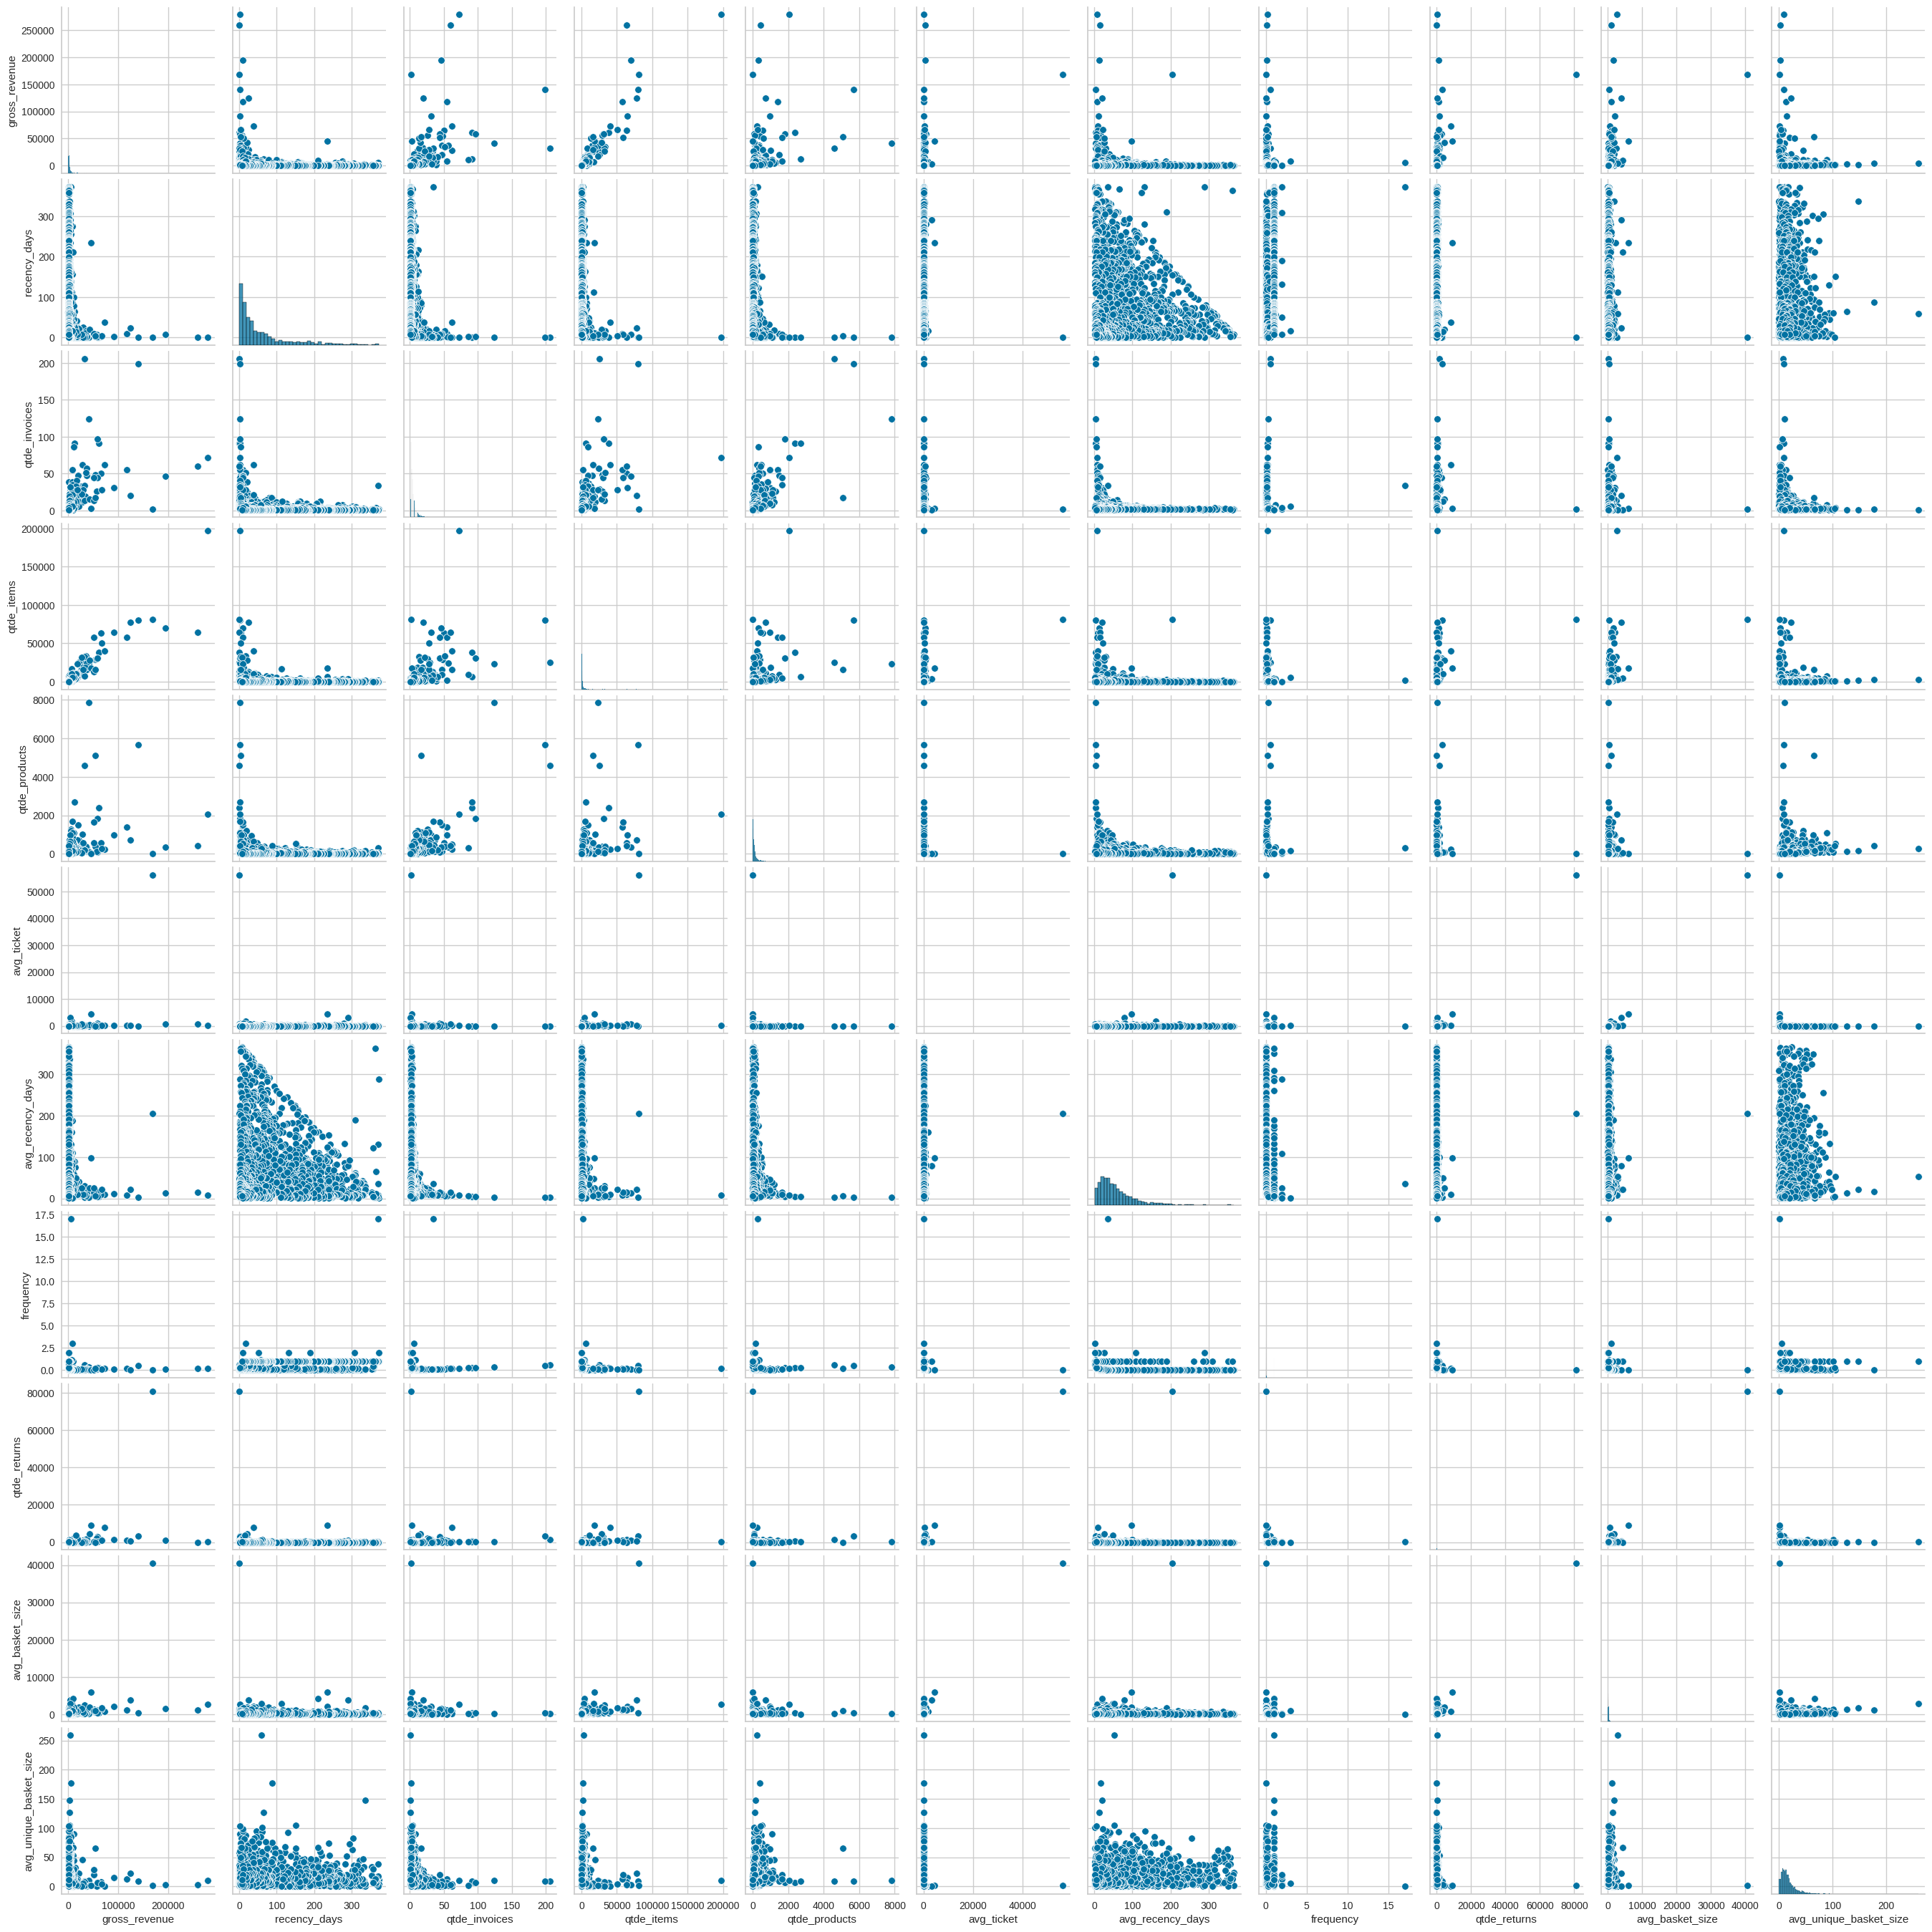

In [95]:
sns.pairplot(df42)
plt.show()

## <span style="color:blue">4.2</span> Study of the Space of Embeddings

In [112]:
df43 = df4.drop(columns=["customer_id"], axis=1).copy()

In [113]:
# Initialize the MinMaxScaler
scaler = pp.MinMaxScaler()

# Select all numeric columns except 'customer_id'
cols_to_scale = df43.select_dtypes(include='number').columns

# Apply MinMax scaling only to the selected columns
df43[cols_to_scale] = scaler.fit_transform(df43[cols_to_scale])

X = df43.copy()

In [114]:
df43.select_dtypes(include='number')

,gross_revenue,recency_days,qtde_invoices,qtde_items,qtde_products,avg_ticket,avg_recency_days,frequency,qtde_returns,avg_basket_size,avg_unique_basket_size
0,0.019292,0.997319,0.160976,0.008799,0.037770,0.000285,0.094521,1.000000,0.000494,0.001234,0.001614
1,0.011559,0.150134,0.039024,0.007056,0.021692,0.000298,0.071918,0.001345,0.000432,0.003789,0.044307
2,0.024000,0.005362,0.068293,0.025538,0.029476,0.000476,0.060788,0.002052,0.000617,0.008252,0.028594
3,0.003375,0.254692,0.019512,0.002225,0.003445,0.000565,0.251142,0.000734,0.000000,0.002143,0.017774
4,0.003116,0.892761,0.009756,0.000401,0.000255,0.005162,0.020822,0.003985,0.000272,0.000634,0.000515
...,...,...,...,...,...,...,...,...,...,...,...
4290,0.001673,0.029491,0.000000,0.001936,0.003700,0.000243,0.008219,0.058522,0.000420,0.009408,0.115147
4305,0.002508,0.018767,0.009756,0.002576,0.001786,0.000800,0.005479,0.043811,0.000617,0.004157,0.017259
4309,0.003891,0.002681,0.009756,0.003719,0.055378,0.000006,0.009589,0.017332,0.000000,0.006009,0.401082
4314,0.001059,0.021448,0.014634,0.001326,0.015184,0.000006,0.000000,0.117364,0.000000,0.001593,0.076507


### 4.3.1 PCA

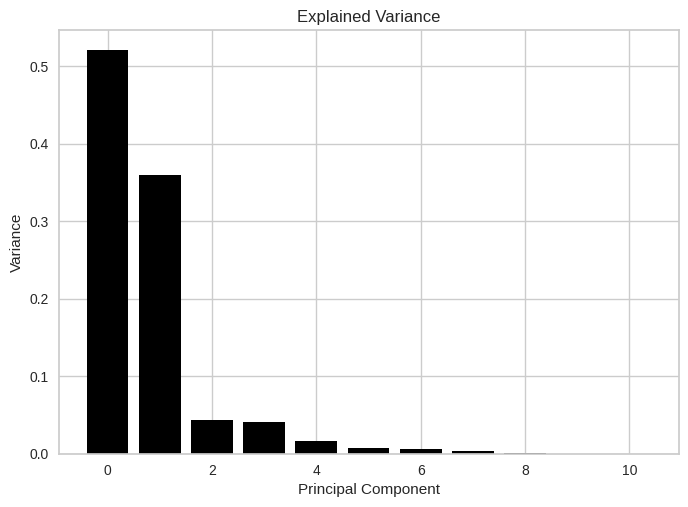

In [118]:

pca = PCA(n_components=X.shape[1])

principal_components = pca.fit_transform(X)

# plot explained variables
features = range(pca.n_components_)

plt.bar(features, pca.explained_variance_ratio_, color='black')
plt.xlabel('Principal Component')
plt.ylabel('Variance')
plt.title('Explained Variance')
plt.show()

# pca components
df_pca = pd.DataFrame(principal_components)

<Axes: xlabel='0', ylabel='1'>

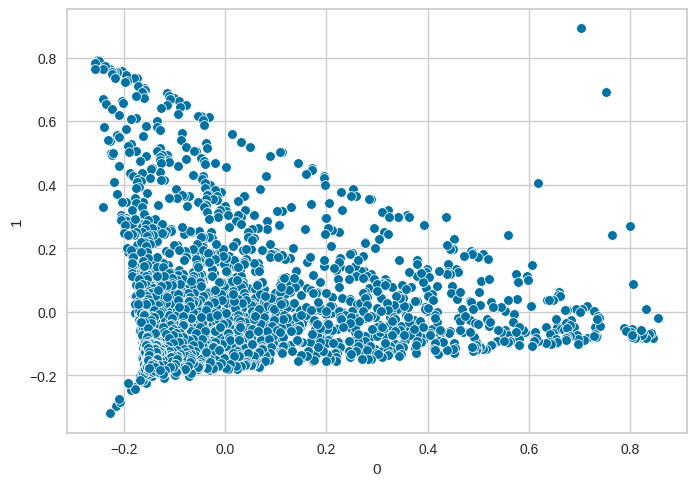

In [120]:
sns.scatterplot(x=0, y=1, data=df_pca)

### ⚠️ Why This PCA Distribution Is Not Suitable for Clustering

1. ❌ **No Clear Separable Groups**
   - The data forms a dense triangular cloud with no visible gaps or natural boundaries.
   - Points lie on a continuous gradient, not in distinct clusters.
   - Clustering algorithms (e.g., K-Means, DBSCAN) work best with well-separated, compact groups.

2. ❌ **High Overlap of Points**
   - Central overlap makes it difficult to distinguish cluster boundaries.
   - This can lead to arbitrary or poor clustering results.

3. ❌ **PCA Doesn’t Optimize for Clustering**
   - PCA focuses on capturing variance, not on separating clusters.
   - The top components may not reflect the actual cluster structure.
   - Variance directions might cut across potential groupings.

### 4.3.2 UMAP

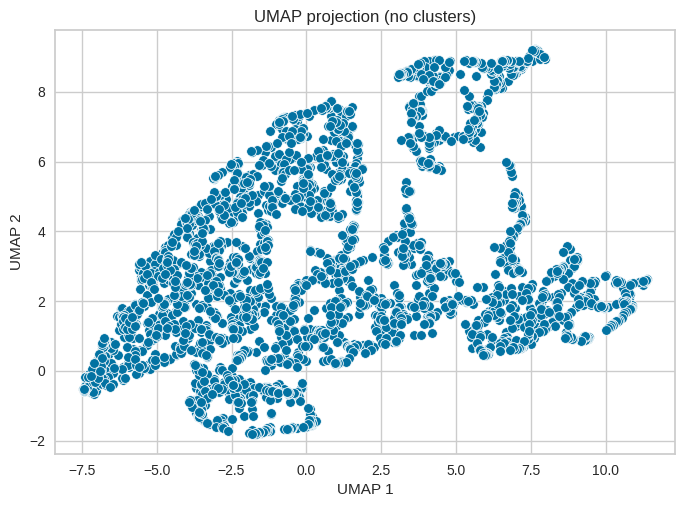

In [122]:
# Fit UMAP and transform the data
reducer = umap.UMAP(random_state=42)
embedding = reducer.fit_transform(X)

# Fit UMAP and transform the data
reducer = umap.UMAP(random_state=42)       # Initialize UMAP with fixed random seed
embedding = reducer.fit_transform(X)       # Fit UMAP on the data and transform it into 2D

# Create a new DataFrame with the UMAP embeddings
df_umap = pd.DataFrame({
    'embedding_x': embedding[:, 0],        # First UMAP component (x-axis)
    'embedding_y': embedding[:, 1]         # Second UMAP component (y-axis)
})

# Plot the UMAP results using seaborn (no clusters yet)
sns.scatterplot(
    x='embedding_x', 
    y='embedding_y', 
    data=df_umap
)

# Show the plot
plt.title('UMAP projection (no clusters)')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.show()

### 4.3.3 t-SNE

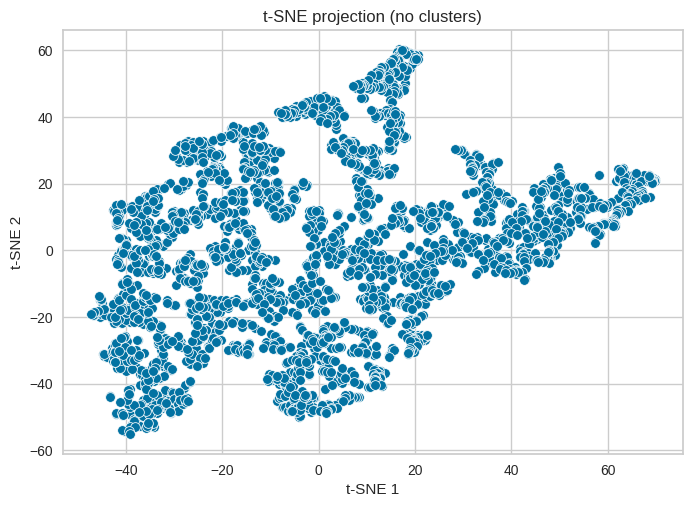

In [126]:
# Fit t-SNE and transform the data
tsne = TSNE(n_components=2, random_state=42, n_jobs=-1)   # Initialize t-SNE to reduce to 2 dimensions
embedding = tsne.fit_transform(X)              # Fit and transform the data (X should be scaled and 2D)

# Create a new DataFrame with the t-SNE embeddings
df_tsne = pd.DataFrame({
    'embedding_x': embedding[:, 0],            # First t-SNE component (x-axis)
    'embedding_y': embedding[:, 1]             # Second t-SNE component (y-axis)
})

# Plot the t-SNE results using seaborn (no clusters yet)
sns.scatterplot(
    x='embedding_x', 
    y='embedding_y', 
    data=df_tsne
)

# Show the plot
plt.title('t-SNE projection (no clusters)')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.show()

### 4.3.3 Tree-Based Embedding

In [133]:
# training dataset
X = df4.drop(columns=['customer_id', 'gross_revenue'], axis=1)
y = df4['gross_revenue']

# model definition
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# model training
rf_model.fit(X, y)

# Leaf
df_leaf = pd.DataFrame(rf_model.apply(X))

df_leaf

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,2984,3165,3369,3328,3032,3149,3229,3126,3173,3126,...,3258,3227,3207,2798,3208,3133,3029,3367,3334,3292
1,2936,3110,3028,2952,3022,3147,2938,2802,3109,3034,...,2502,2920,2951,2758,3137,3055,2935,2925,2976,2830
2,3490,3617,3577,3405,3593,3618,3537,3545,3701,3615,...,3602,3473,3564,3544,3615,3564,3576,3615,3592,3665
3,2129,1963,1570,1598,1829,1508,2105,1787,2043,2115,...,1804,1366,2052,2082,2050,2168,1526,1000,2179,2103
4,216,270,298,594,175,468,725,693,174,165,...,422,209,684,586,693,739,575,907,697,207
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2964,818,1295,917,987,1265,1119,1264,768,924,1202,...,1310,955,779,1237,1306,837,1003,961,1267,1302
2965,1459,1406,1945,1978,1319,1770,1648,1486,1417,1307,...,1500,1308,1616,1622,1970,1532,1726,1529,1808,1490
2966,1778,2429,1747,2111,2084,1705,1880,1927,1956,1934,...,2057,2127,1922,1743,1651,2046,1973,1698,1502,1839
2967,985,847,775,1155,817,808,886,807,1188,900,...,863,1205,897,883,1198,882,668,572,828,1054


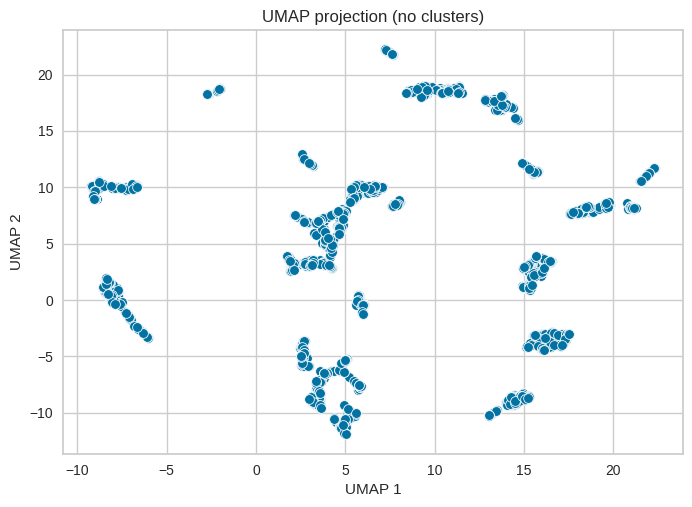

In [136]:
# Apply UMAP in df_leaf

# Fit UMAP and transform the data
reducer = umap.UMAP(random_state=42)       # Initialize UMAP with fixed random seed
embedding = reducer.fit_transform(df_leaf)       # Fit UMAP on the data and transform it into 2D

# Create a new DataFrame with the UMAP embeddings
df_umap = pd.DataFrame({
    'embedding_x': embedding[:, 0],        # First UMAP component (x-axis)
    'embedding_y': embedding[:, 1]         # Second UMAP component (y-axis)
})

# Plot the UMAP results using seaborn (no clusters yet)
sns.scatterplot(
    x='embedding_x', 
    y='embedding_y', 
    data=df_umap
)

# Show the plot
plt.title('UMAP projection (no clusters)')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.show()

# <font color='blue'> 🛠️ 5.0 Data Sculpting: Preparing for Modeling

In [ ]:
df5 = df4.copy()

In [90]:
df5.head()

,customer_id,gross_revenue,recency_days,frequency,avg_ticket,returns_count
0,17850,5391.21,372.0,34.0,18.152222,1.0
1,13047,3232.59,56.0,9.0,18.904035,7.0
2,12583,6705.38,2.0,15.0,28.902500,2.0
3,13748,948.25,95.0,5.0,33.866071,0.0
4,15100,876.00,333.0,3.0,292.000000,3.0


In [ ]:
mm = pp.MinMaxScaler()
df5[['gross_revenue']] = mm.fit_transform(df5[['gross_revenue']])
df5[['recency_days']] = mm.fit_transform(df5[['recency_days']])
df5[['frequency']] = mm.fit_transform(df5[['frequency']])
df5[['avg_ticket']] = mm.fit_transform(df5[['avg_ticket']])
df5[['returns_count']] = mm.fit_transform(df5[['returns_count']])

# <font color='blue'> 🎯 6.0 Feature Spotlight: Selecting the Best Predictors

In [92]:
df6 = df5.copy()

# <font color='blue'> 🔍 7.0 Hyperparameter Fine-Tuning

In [93]:
X = df6.drop(columns=['customer_id']).copy()

In [94]:
clusters = np.arange(2, 8)

## <span style="color:blue">7.1</span> Whithin Sum of Squares (WSS)

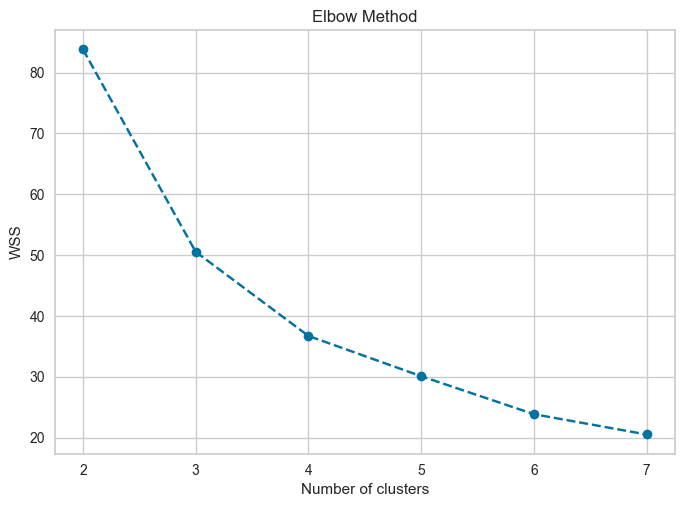

In [95]:
wss = []
for k in clusters:
    # model definition
    Kmeans = KMeans(n_clusters=k, n_init=10, max_iter=300, random_state=42)

    # model trainin
    Kmeans.fit(X)

    # validation
    wss.append(Kmeans.inertia_)

plt.plot(clusters, wss, linestyle='--', marker='o', color='b')
plt.xlabel('Number of clusters')
plt.ylabel('WSS')
plt.title('Elbow Method')
plt.show()

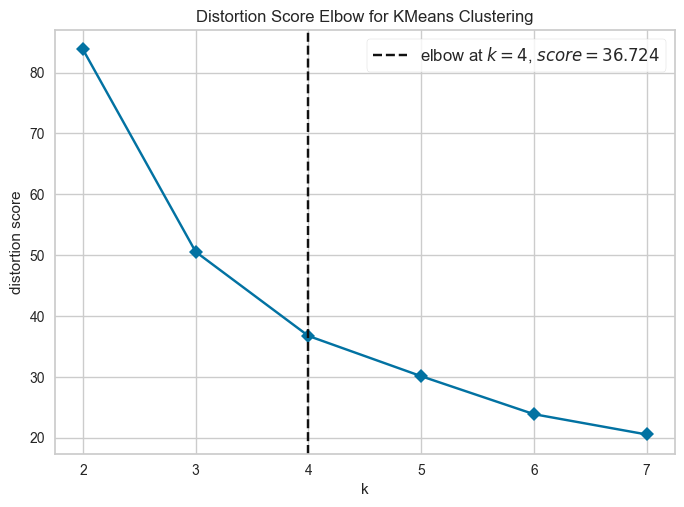

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [96]:
kmeans = KElbowVisualizer(Kmeans, k=clusters, timings=False)
kmeans.fit(X)
kmeans.show()


## <span style="color:blue">7.2</span> Silhouette Score

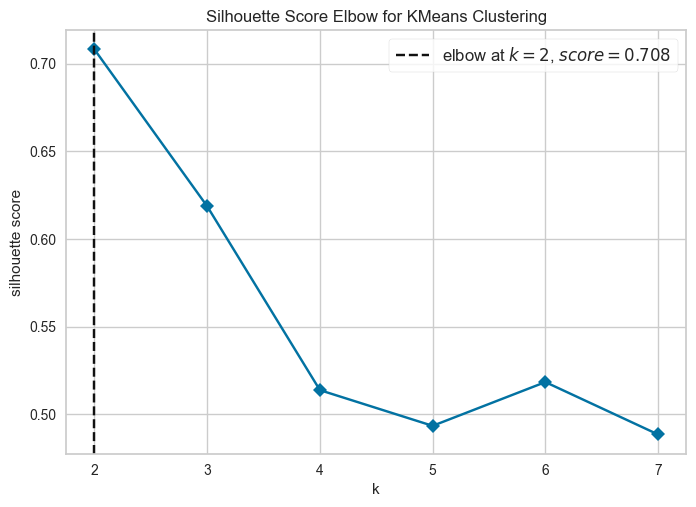

<Axes: title={'center': 'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [97]:
kmeans = KElbowVisualizer(Kmeans, k=clusters, metric='silhouette', timings=False)
kmeans.fit(X)
kmeans.show()

## <span style="color:blue">7.3</span>  Silhouette Analysis

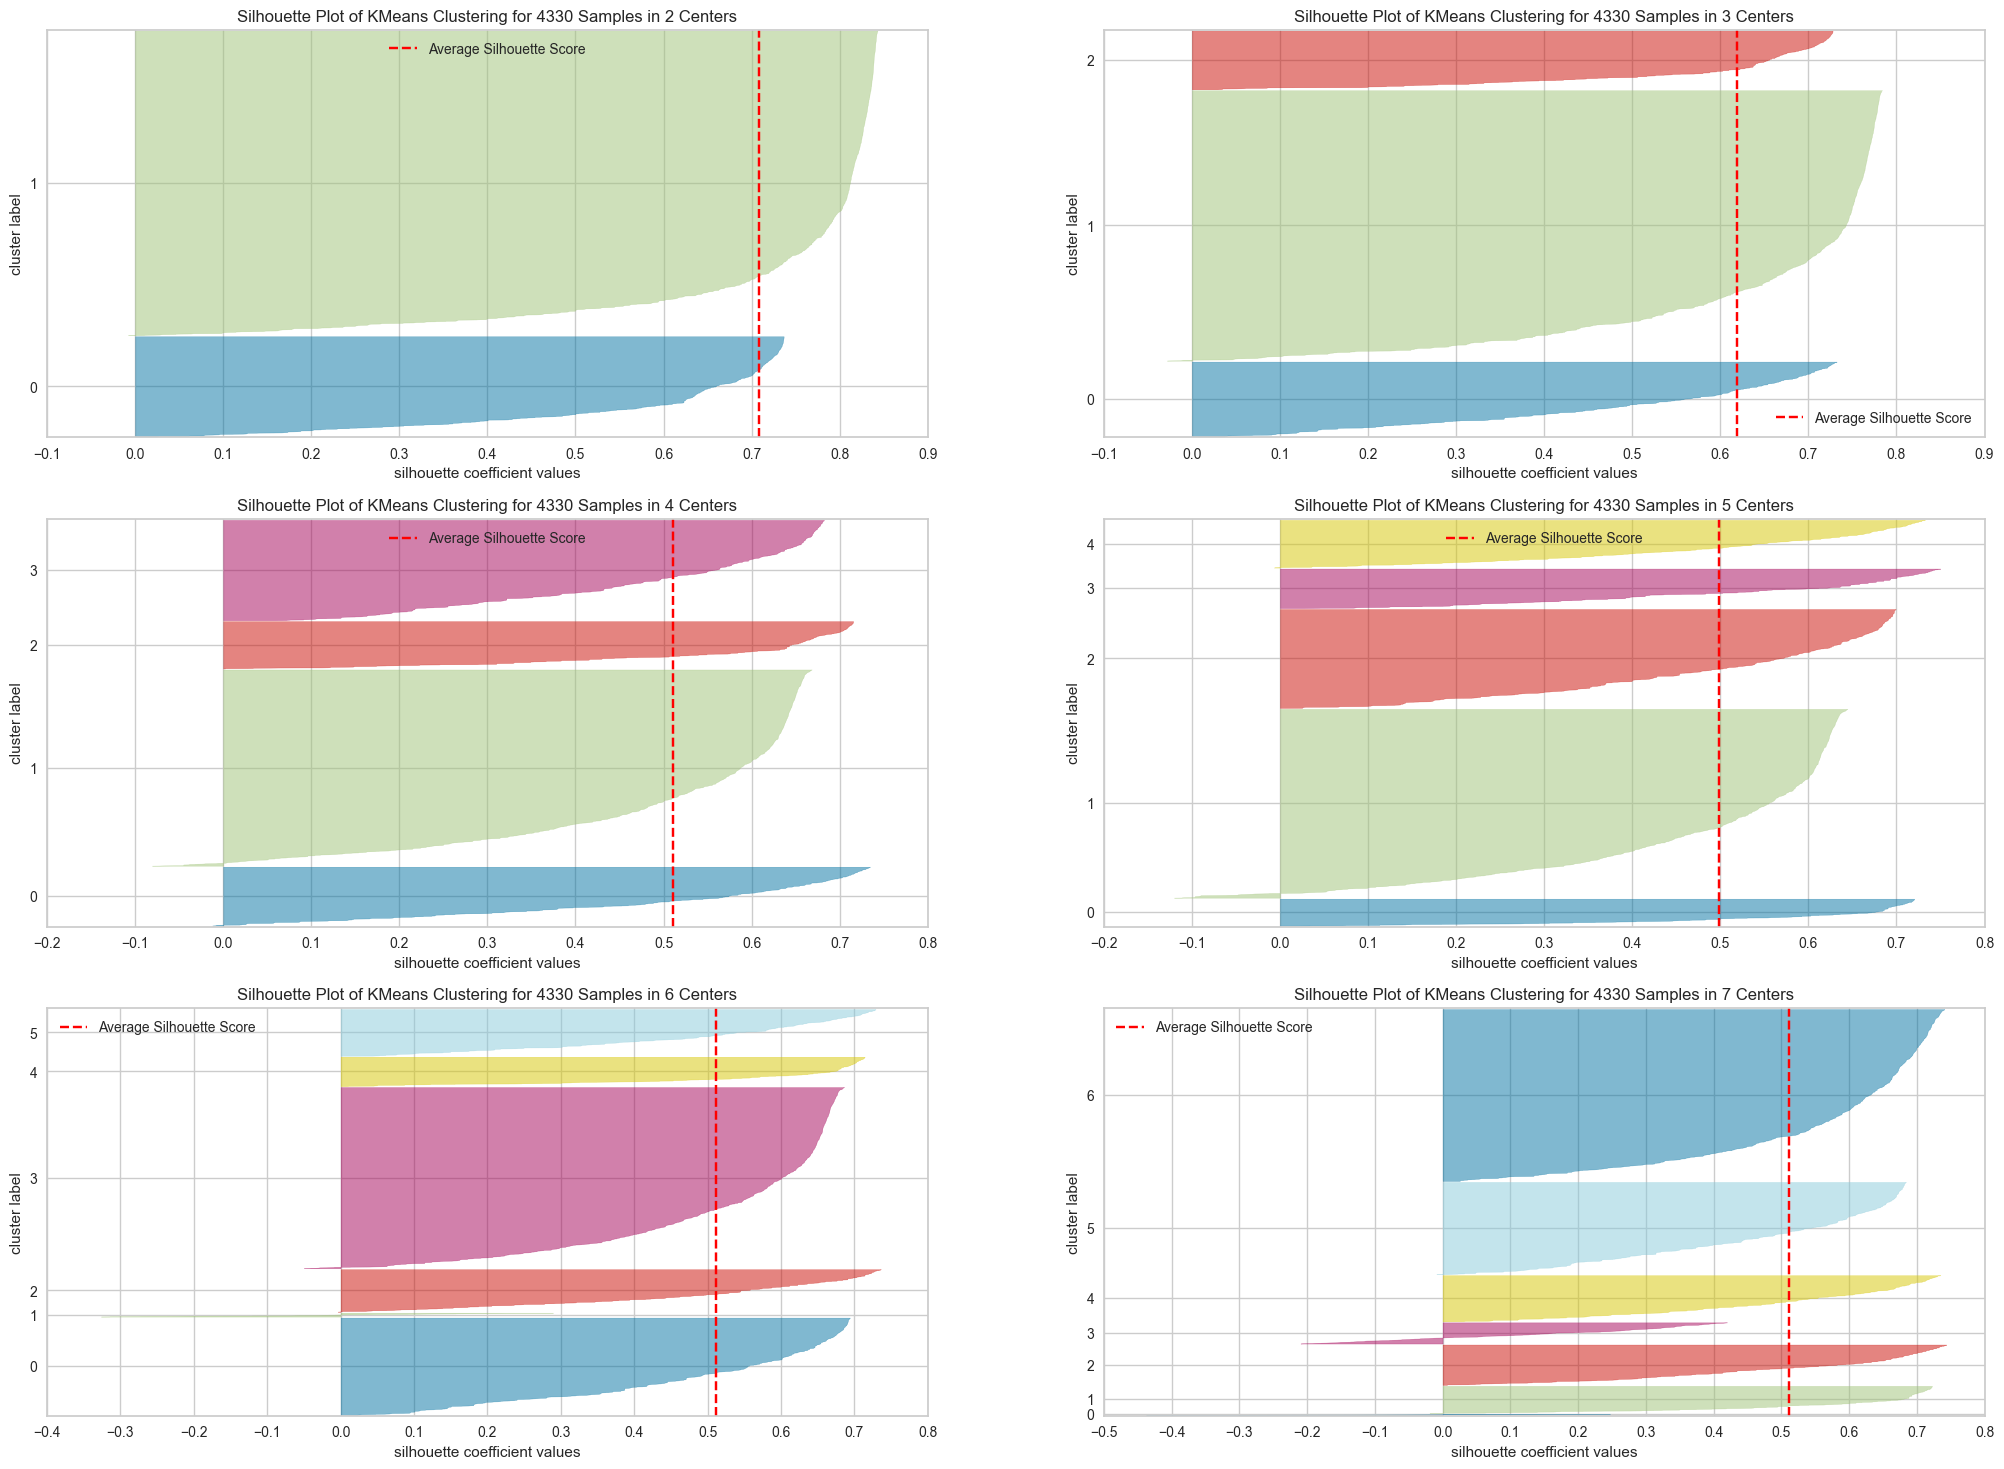

In [98]:
fig, ax = plt.subplots(3, 2, figsize=(25, 18))
for k in clusters:
    
    km = KMeans(n_clusters=k, init='random', n_init=10, max_iter=100, random_state=42)
    q, mod = divmod(k, 2)

    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q-1, mod])
    visualizer.fit(X)
    visualizer.finalize()

# <font color='blue'> 🚀 8.0 Model Training

## <span style="color:blue">8.1</span>  K-means

In [99]:
# model definition
k=5
model_kmeans = KMeans(init='random', n_clusters=k, n_init=10, max_iter=300, random_state=84)

# model training
model_kmeans.fit(X)

# Clustering
labels = model_kmeans.labels_

# Check unique clusters
print(np.unique(labels))

[0 1 2 3 4]


## <span style="color:blue">8.2</span> Cluster Validation

In [100]:
## WSS (Within-cluster sum of squares)
print('WSS value: ', model_kmeans.inertia_)

## Silhouette Score
print('SS value {}:'.format( silhouette_score(X, labels, metric='euclidean') ))

WSS value:  30.12335050861708
SS value 0.4989258254668902:


# <font color='blue'> 🌐 9.0 Cluster Analysis: Unveiling Hidden Patterns

In [101]:
df9 = df6.copy()
df9['cluster'] = labels
df9.head()

,customer_id,gross_revenue,recency_days,frequency,avg_ticket,returns_count,cluster
0,17850,0.019301,0.997319,0.160976,0.000208,0.022222,1
1,13047,0.011567,0.150134,0.039024,0.000218,0.155556,0
2,12583,0.024009,0.005362,0.068293,0.000347,0.044444,4
3,13748,0.003384,0.254692,0.019512,0.000412,0.000000,0
4,15100,0.003125,0.892761,0.009756,0.003756,0.066667,1


## <span style="color:blue">9.1</span> Visualizaion Inspection

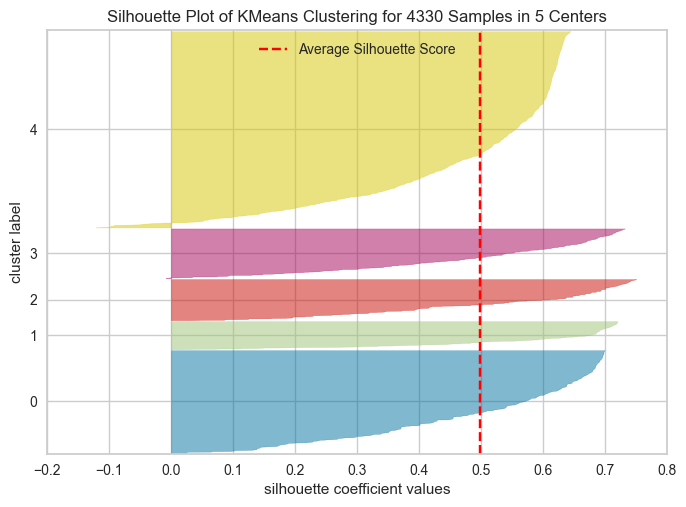

In [102]:
visualizer = SilhouetteVisualizer(model_kmeans, colors='yellowbrick')
visualizer.fit(X)
visualizer.finalize()

## <span style="color:blue">9.2</span> 2d plot

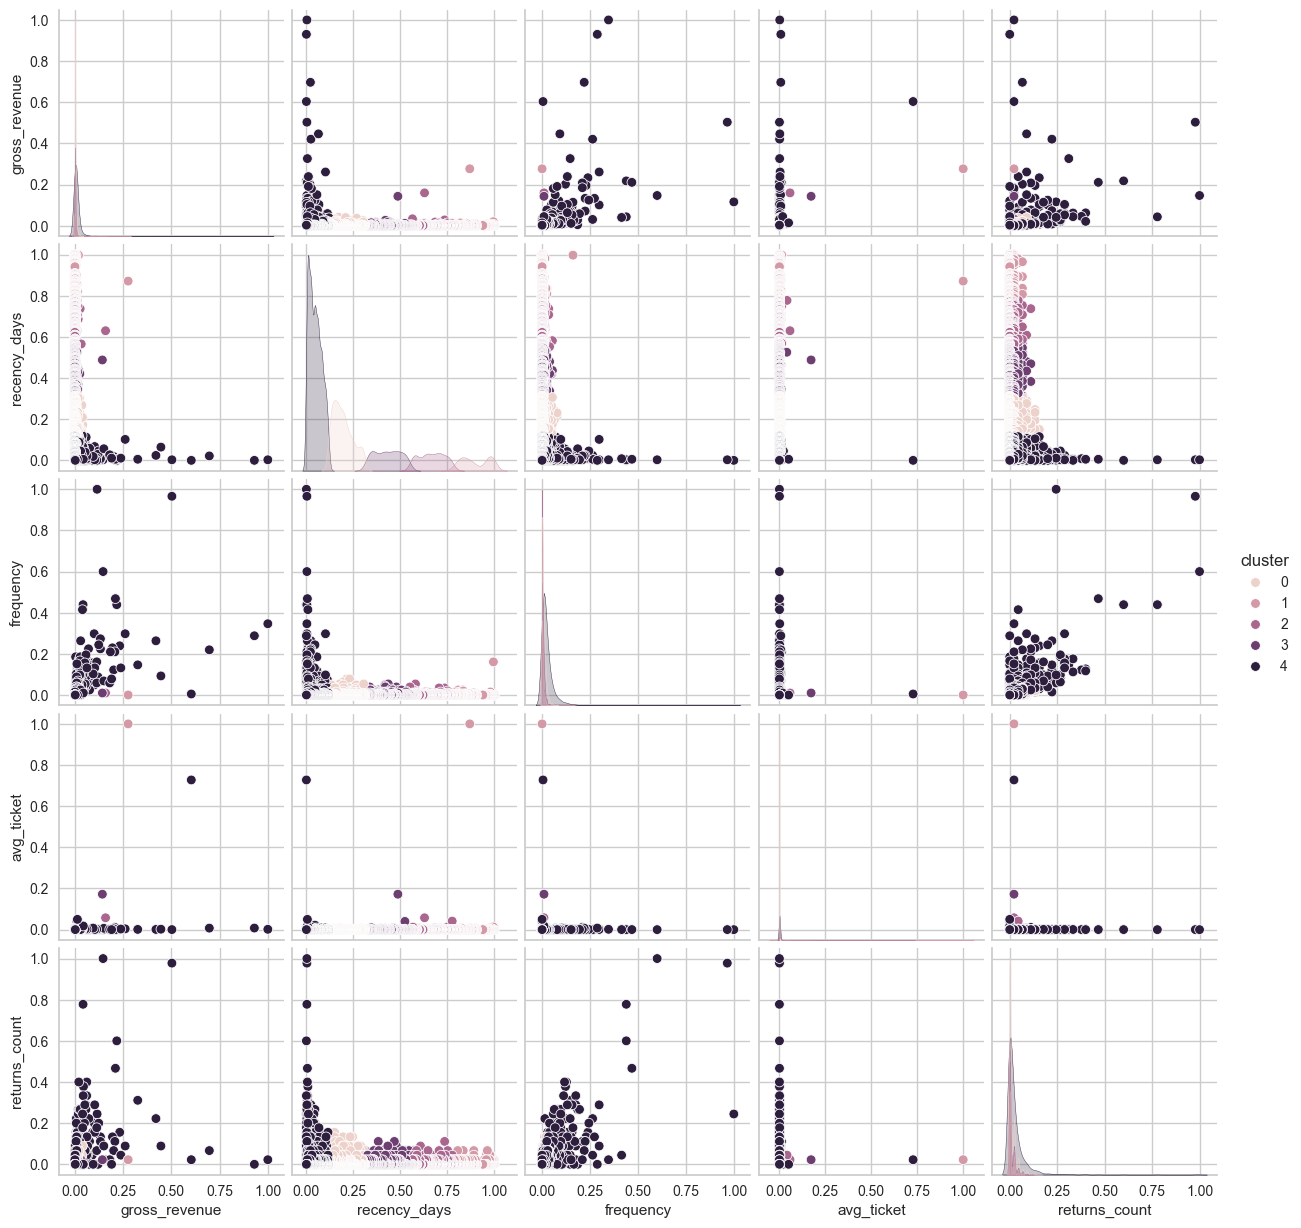

In [103]:
df_viz = df9.drop(columns=['customer_id'])
sns.pairplot(df_viz, hue='cluster')

## <span style="color:blue">9.3</span> UMAP

In [ ]:
reducer = umap.UMAP(n_neighbors=1905, random_state=42)
embedding = reducer.fit_transform(X)

# embedding
df_viz['embedding_x'] = embedding[:, 0]
df_viz['embedding_y'] = embedding[:, 1]

# plot UMAP
sns.scatterplot(x='embedding_x', y='embedding_y', hue='cluster', 
                palette= sns.color_palette('hls', n_colors=df_viz['cluster'].nunique()), 
                data=df_viz)

## <span style="color:blue">9.4</span> Cluster Profile

In [92]:
df9.head()

,customer_id,gross_revenue,recency_days,frequency,avg_ticket,cluster
0,17850,5288.63,302,35,16.950737,1
1,13047,3079.10,31,18,15.709694,2
2,12583,7187.34,2,18,28.634821,1
3,13748,948.25,95,5,33.866071,2
4,15100,635.10,330,6,105.850000,2


In [95]:
# Number os customers
df_cluster = df9[['cluster', 'customer_id']].groupby('cluster').count().reset_index().rename(columns={'customer_id': 'count_customer'})
df_cluster['perc_customer'] = df_cluster['count_customer'] / df_cluster['count_customer'].sum() * 100

# Avg Gross Revenue
df_cluster['avg_gross_revenue'] = df9[['cluster', 'gross_revenue']].groupby('cluster').mean().reset_index()['gross_revenue']

# Avg Recency Days
df_cluster['avg_recency_days'] = df9[['cluster', 'recency_days']].groupby('cluster').mean().reset_index()['recency_days']

# Avg Frequency
df_cluster['avg_frequency'] = df9[['cluster', 'frequency']].groupby('cluster').mean().reset_index()['frequency']

# Avg Ticket
df_cluster['mean_avg_ticket '] = df9[['cluster', 'avg_ticket']].groupby('cluster').mean().reset_index()['avg_ticket']

df_cluster

,cluster,count_customer,perc_customer,avg_gross_revenue,avg_recency_days,avg_frequency,mean_avg_ticket
0,0,6,0.137237,182181.981667,7.166667,89.000000,253.626345
1,1,267,6.107045,8089.028652,20.280899,19.528090,62.783157
2,2,4071,93.115279,946.696250,96.969295,3.641120,25.359654
3,3,28,0.640439,42614.387143,6.178571,57.821429,162.862605


### Cluster 00: Extremely High-Value Customers (Revenue & Frequency Focus)

* **Number of Customers:** 6 (0.14% of customers) - A very small, but extremely valuable group.
* **Average Recency:** 7 days - Very recent customers, indicating continuous engagement.
* **Average Number of Purchases (Frequency):** 89 purchases - Extremely frequent customers.
* **Average Total Revenue (per customer):** R$ 182,181.98 - Customers who generate the highest *accumulated* revenue individually.
* **Average Ticket Size (per purchase):** R$ 253.63 - The average amount spent *per single purchase*.

---

### Cluster 01: Medium-to-High Value Customers (Good Engagement & Solid Revenue)

* **Number of Customers:** 267 (6.11% of customers) - A reasonably sized group.
* **Average Recency:** 20 days - Still quite recent, but slightly less so than Cluster 00.
* **Average Number of Purchases (Frequency):** 20 purchases - Good frequency, indicating loyalty.
* **Average Total Revenue (per customer):** R$ 8,089.03 - Customers who contribute significantly to the total revenue.
* **Average Ticket Size (per purchase):** R$ 62.78 - Good average ticket size, boosted by frequency.

---

### Cluster 02: Low-Value Customers (Highest Volume, Lower Engagement)

* **Number of Customers:** 4,071 (93.12% of customers) - The vast majority of the customer base.
* **Average Recency:** 97 days - Older customers or those with less recent activity.
* **Average Number of Purchases (Frequency):** 4 purchases - Low frequency, indicating sporadic purchases.
* **Average Total Revenue (per customer):** R$ 946.70 - Individually contribute low revenue.
* **Average Ticket Size (per purchase):** R$ 25.36 - The lowest average ticket size.

---

### Cluster 03: High-Value Customers (Very High Recency & Frequency)

* **Number of Customers:** 28 (0.64% of customers) - A small but very valuable group.
* **Average Recency:** 6 days - Extremely recent, even surpassing Cluster 00 on average.
* **Average Number of Purchases (Frequency):** 58 purchases - Very high purchase frequency.
* **Average Total Revenue (per customer):** R$ 42,614.39 - Generate a very high individual revenue.
* **Average Ticket Size (per purchase):** R$ 162.86 - Significantly high average ticket size.

---

# <font color='blue'> ✨ 10.0 Deploy to Production